In [1]:
# Drop variables that don't seem to be contributing much of have problems
# (Wave 9 variables, high (anti-/)correlation variables, mostly not filled out, very low variance, too many categories)
# Transform variables (making some more easily readable
# and dummying non-ordinal categorical variables to create lots of new variables)
# rechecking if those new variables suffer from excessive levels of correlation

# Output: 
# BES_reduced - imputed dataset post-transformation
# BES_reduced_with_na - non-imputed dataset post-transformation


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

from utility import *

In [3]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

In [4]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [5]:
dataset_name = "W19_comb"

In [6]:
# %%time

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

filename = manifest["Stata_Filename"].values[0]

BES_Panel  = pd.read_pickle(data_subfolder + filename.replace('.dta','.zip'),compression='zip')
print("BES_Panel", BES_Panel.shape )


# BES_numeric = pd.read_msgpack( data_subfolder + "BESnumeric.msgpack" )
BES_numeric = pd.read_pickle( data_subfolder + "BESnumeric.zip", compression='zip' )
print("BES_numeric",  BES_numeric.shape )

try:
    var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
    var_type.set_index("Unnamed: 0", inplace=True)
except:
    var_type    = pd.read_hdf( data_subfolder + "var_type.hdf", encoding=encoding)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )

BES_Panel (97158, 7911)
BES_numeric (97158, 7634)
var_type (7911, 14)


In [149]:
# BES_numeric = BES_numeric.sparse.to_dense()

In [7]:
BES_numeric.dtypes.value_counts()

Int8       4406
boolean    3152
Int32        49
Int16        24
float32       3
dtype: int64

{'ukCitizenW1': BooleanDtype,
 'euCitizenW1': BooleanDtype,
 'commonwealthCitizenW1': BooleanDtype,
 'otherCitizenW1': BooleanDtype,
 'bestOnMIIW1': Int8Dtype(),
 'turnoutUKGeneralW1': Int8Dtype(),
 'turnoutUKGeneralW2': Int8Dtype(),
 'turnoutUKGeneralW3': Int8Dtype(),
 'turnoutUKGeneralW4': Int8Dtype(),
 'turnoutUKGeneralW5': Int8Dtype(),
 'turnoutUKGeneralW7': Int8Dtype(),
 'turnoutUKGeneralW8': Int8Dtype(),
 'turnoutUKGeneralW9': Int8Dtype(),
 'turnoutUKGeneralW10': Int8Dtype(),
 'turnoutUKGeneralW11': Int8Dtype(),
 'turnoutUKGeneralW12': Int8Dtype(),
 'turnoutUKGeneralW14': Int8Dtype(),
 'turnoutUKGeneralW15': Int8Dtype(),
 'turnoutUKGeneralW16': Int8Dtype(),
 'turnoutUKGeneralW17': Int8Dtype(),
 'turnoutUKGeneralW18': Int8Dtype(),
 'generalElectionVoteW1': Int8Dtype(),
 'generalElectionVoteW2': Int8Dtype(),
 'generalElectionVoteW3': Int8Dtype(),
 'generalElectionVoteW4': Int8Dtype(),
 'generalElectionVoteUnsqueezeW4': Int8Dtype(),
 'generalElectionVoteSqueezeW4': Int8Dtype(),
 'ge

In [9]:
%%time
medians = BES_numeric.astype('float32').median()

Wall time: 2min 51s


In [18]:
BES_numeric.dtypes.apply(lambda x: str(x.name)).to_dict()

{'ukCitizenW1': 'boolean',
 'euCitizenW1': 'boolean',
 'commonwealthCitizenW1': 'boolean',
 'otherCitizenW1': 'boolean',
 'bestOnMIIW1': 'Int8',
 'turnoutUKGeneralW1': 'Int8',
 'turnoutUKGeneralW2': 'Int8',
 'turnoutUKGeneralW3': 'Int8',
 'turnoutUKGeneralW4': 'Int8',
 'turnoutUKGeneralW5': 'Int8',
 'turnoutUKGeneralW7': 'Int8',
 'turnoutUKGeneralW8': 'Int8',
 'turnoutUKGeneralW9': 'Int8',
 'turnoutUKGeneralW10': 'Int8',
 'turnoutUKGeneralW11': 'Int8',
 'turnoutUKGeneralW12': 'Int8',
 'turnoutUKGeneralW14': 'Int8',
 'turnoutUKGeneralW15': 'Int8',
 'turnoutUKGeneralW16': 'Int8',
 'turnoutUKGeneralW17': 'Int8',
 'turnoutUKGeneralW18': 'Int8',
 'generalElectionVoteW1': 'Int8',
 'generalElectionVoteW2': 'Int8',
 'generalElectionVoteW3': 'Int8',
 'generalElectionVoteW4': 'Int8',
 'generalElectionVoteUnsqueezeW4': 'Int8',
 'generalElectionVoteSqueezeW4': 'Int8',
 'generalElectionVoteW5': 'Int8',
 'generalElectionVotePostW5': 'Int8',
 'generalElectionVoteUnsqueezeW5': 'Int8',
 'generalElectio

In [21]:
%%time
BES_imputed = BES_numeric.astype( 'float32' ).fillna(medians)
gc.collect()

Wall time: 41.8 s


0

In [26]:
BES_imputed = BES_imputed.apply(lambda x: pd.to_numeric( x , downcast='unsigned' ) )

In [27]:
BES_imputed.dtypes.value_counts()

uint8      7585
uint16       29
float32      12
uint32        8
dtype: int64

In [10]:
BES_imputed = BES_numeric.fillna(medians)
print("BES_imputed",  BES_imputed.shape )

20

In [32]:
# %%time
# imputation_method = "mice" # "mice", "softimpute", "median", ???
# imputed_file_name = "BES" + imputation_method + wave

# imputation_method = "median" # "mice", "softimpute", "median", ???
# imputed_file_name = "BES" + imputation_method + wave


# BES_imputed = pd.read_hdf( BES_data_folder + imputed_file_name  + ".hdf", imputed_file_name )
# BES_numeric.replace(-1,np.nan,inplace=True)
# BES_imputed = BES_numeric.fillna(BES_numeric.median())


In [19]:
# bool_vars = BES_numeric.columns[BES_numeric.dtypes=="boolean"]
# BES_numeric[bool_vars] = BES_numeric[bool_vars].astype('Int8')

In [116]:
# England_inds = BES_Panel[BES_Panel["country"]=="England"].index
# print ( "respondents not from England: ", len(BES_Panel) - len(England_inds) )
# Remain_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==0 ].index
# Leave_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==1 ].index
# Notvoters_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==2 ].index
# Dontknow_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==3 ].index
# print ( "respondents not Remain/Leave: ", len(BES_Panel) - len(Remain_inds) - len(Leave_inds) )
# Leave_Remain_inds = pd.Index( np.concatenate( (Leave_inds, Remain_inds), axis=0 ) )
# EngRemLea_inds = pd.Index( np.intersect1d( England_inds, Leave_Remain_inds ) )

In [117]:
# W9_vars = pd.Index([x for x in BES_numeric.columns if "W9" in x])
# print ( "W9 columns: ", W9_vars )

In [118]:
# W9_vars = []

In [35]:
opts_per_cat = BES_numeric.apply(lambda x: len(pd.unique(x.dropna()))).sort_values()
many_cat_drop_list = opts_per_cat[opts_per_cat>60].index
# added to make sure we're only dropping *categorical* variables with lots of categories!
many_cat_drop_list = [x for x in var_type.loc[many_cat_drop_list].index
                      if var_type.loc[many_cat_drop_list].loc[x]["type"] in [3,7]]
print("many_cat_drop_list", many_cat_drop_list )

many_cat_drop_list ['profile_leaW7', 'profile_lea', 'euRefLA', 'profile_oslaua', 'pconW14', 'pconW19', 'profile_mpnameW2', 'pconW16', 'profile_mpnameW3', 'pconW15', 'pconW17', 'pconW2', 'pconW3', 'pconW11', 'mpNameW1', 'pconW1', 'pconW10', 'pconW9', 'pconW8', 'pconW13', 'pconW7', 'pconW5', 'pconW12', 'pconW6']


In [120]:
# %%time
# counts = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count()
# counts_by_individuals = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count(axis=1) # lets see
# f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
# axarr[0].hist(counts,bins=50)
# axarr[1].hist(counts_by_individuals,bins=50)

In [121]:
# drop people who are coverage outliers
# say top and bottom 5%
# BES_red = BES_numerics_only.loc[BES_reduced["wave9"]==1 ].copy()

In [122]:
# thresh = .00
# BES_red = BES_numeric.copy()
# BES_red["coverage"] = BES_numeric.count(axis=1)/BES_numeric.shape[1]

# outlier_people = BES_red[( BES_red["coverage"]>BES_red["coverage"].quantile(1-thresh) ) | 
#                          ( BES_red["coverage"]<BES_red["coverage"].quantile(  thresh) ) ].index
# inlier_people  = BES_red[( BES_red["coverage"]<BES_red["coverage"].quantile(1-thresh) ) & 
#                          ( BES_red["coverage"]>BES_red["coverage"].quantile(  thresh) ) ].index

Wall time: 6.84 s


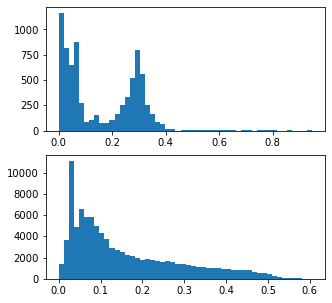

In [11]:
%%time
# columns histogrammed by %non-missing values
# rows histogrammed by %non-missing values

counts = BES_numeric.count()/BES_numeric.shape[0]
counts_by_individuals = BES_numeric.count(axis=1)/BES_numeric.shape[1] # lets see
f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
ax = axarr[0].hist(counts,bins=50)
ax = axarr[1].hist(counts_by_individuals,bins=50)

In [12]:
# In theory, this is picked on the basis of looking at the above two diagrams (really, the top one!)
# thresh = 0.33
# missing_value_thresh = 0.33
missing_value_thresh = 0.05

mostly_not_filled_out = counts[counts<= (counts.max()*missing_value_thresh)].index
mostly_filled_out     = counts[counts>  (counts.max()*missing_value_thresh)].index

In [125]:
# missing_value_thresh = 0.8

# mostly_not_filled_out = counts[counts<= (counts.max()*missing_value_thresh)].index
# mostly_filled_out     = counts[counts>  (counts.max()*missing_value_thresh)].index

In [13]:
print(BES_numeric[mostly_filled_out].shape)
missing_fraction = BES_numeric[mostly_filled_out].isnull().sum().sum() / \
    (BES_numeric[mostly_filled_out].shape[0]*BES_numeric[mostly_filled_out].shape[1])
print(missing_fraction)

(97158, 5375)
0.7845261111486109


In [127]:
# %%time
# frac=.2
# BES_numeric.sample(frac=frac).sample(frac=frac, axis=1).shape
# np.corrcoef( BES_numeric.sample(frac=frac).sample(frac=frac, axis=1) )
# BES_numeric.sample(frac=frac).sample(frac=frac, axis=1).corr(min_periods=100, method='pearson')



In [31]:
memory_use(locs = locals().items())

                   BES_numeric:   1.4GiB
                     BES_Panel: 797.6MiB
                   BES_imputed: 716.3MiB
                      var_type:   6.3MiB
                           _23:   1.6MiB
                           _16:   1.3MiB
                           _17:   1.3MiB
                           _15:   1.1MiB
                       medians: 900.9KiB
                           _11: 900.9KiB


In [34]:
%%time
corrs = np.corrcoef(BES_imputed)

MemoryError: Unable to allocate array with shape (97158, 7634) and data type float64

In [129]:
%%time
# 0.05, 0.0025: 2.34
# 0.10, 0.01: 10.7s
# 0.10, spearman: 27s
# 0.10, kendall: 56s
# 0.15, 0.0225, pearson: 29s
# 0.20, 0.04, pearson: 65s
# 30 mins?
# W14_only: 55s
try:
    corr_mat = pd.read_pickle(BES_data_folder+dataset_name+os.sep+"corr_df.zip",compresison='zip')
except:
    corr_mat = BES_numeric.corr()
    corr_mat.to_pickle(BES_data_folder+dataset_name+os.sep+"corr_df.zip",compresison='zip')

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\IPython\core\magics\execution.py:1310: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code, glob, local_ns)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  del sys.path[0]


Wall time: 2h 15min 58s


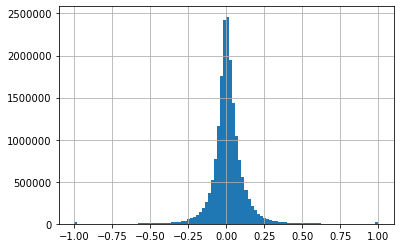

In [130]:
# %%time
## 5 minutes!
## 8h 41min 19s on W10_comb panel!

# data = BES_numeric
# corr_mat = BES_numeric.corr()

# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

In [131]:
# build a data frame of pairs of highly corr/anti-corr variables
# score on correlation, %non-missing values for each
# Building the high_corr_list is still **manual** (not much reason to automate)


corr_df = pd.DataFrame(columns = ["var1","var2","corr","var1%","var2%","min var%"])

id_num = 0

# min_filled_out = 0.02
min_filled_out = 0.02

thresh = .05
x = ( ( corr_mat>(1-thresh) ) &mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = BES_numeric[a].notnull().mean()
    d = BES_numeric[b].notnull().mean()
    mincd = min(c,d)
    if mincd > min_filled_out:
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1


x = ( ( corr_mat<(thresh-1) ) &mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = BES_numeric[a].notnull().mean()
    d = BES_numeric[b].notnull().mean()
    mincd = min(c,d)
    if (mincd > min_filled_out):
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1

corr_df

var1                   var2  corr     var1%  \
0      generalElectionVoteUnsqueezeW4  generalElectionVoteW4   1.0  0.222990   
1        generalElectionVoteSqueezeW4  generalElectionVoteW4   1.0  0.068001   
2           generalElectionVotePostW5  generalElectionVoteW5   1.0  0.033050   
3      generalElectionVoteUnsqueezeW5  generalElectionVoteW5   1.0  0.207092   
4        generalElectionVoteSqueezeW5  generalElectionVoteW5   1.0  0.051724   
...                               ...                    ...   ...       ...   
18564                small_mii_catW11        europeannessW12  -1.0  0.279089   
18565                small_mii_catW11   econPersonalRetroW12  -1.0  0.279089   
18566                small_mii_catW11        econGenRetroW12  -1.0  0.279089   
18567                small_mii_catW11           immigSelfW12  -1.0  0.279089   
18568                small_mii_catW11            immigLabW12  -1.0  0.279089   

          var2%  min var%  
0      0.290991  0.222990  
1      0.290991  0.068001  
2      0.291866  0.033050  
3      0.291866  0.207092  
4      0.291866  0.051724  
...         ...       ...  
18564  0.093566  0.093566  
18565  0.093523  0.093523  
18566  0.090347  0.090347  
18567  0.089203  0.089203  
18568  0.077873  0.077873  

[18569 rows x 6 columns]

In [132]:
# corr_df.to_hdf(BES_data_folder+"corr_dfW10Panel.hdf","corr_dfW10Panel")


In [133]:
corr_df

var1                   var2  corr     var1%  \
0      generalElectionVoteUnsqueezeW4  generalElectionVoteW4   1.0  0.222990   
1        generalElectionVoteSqueezeW4  generalElectionVoteW4   1.0  0.068001   
2           generalElectionVotePostW5  generalElectionVoteW5   1.0  0.033050   
3      generalElectionVoteUnsqueezeW5  generalElectionVoteW5   1.0  0.207092   
4        generalElectionVoteSqueezeW5  generalElectionVoteW5   1.0  0.051724   
...                               ...                    ...   ...       ...   
18564                small_mii_catW11        europeannessW12  -1.0  0.279089   
18565                small_mii_catW11   econPersonalRetroW12  -1.0  0.279089   
18566                small_mii_catW11        econGenRetroW12  -1.0  0.279089   
18567                small_mii_catW11           immigSelfW12  -1.0  0.279089   
18568                small_mii_catW11            immigLabW12  -1.0  0.279089   

          var2%  min var%  
0      0.290991  0.222990  
1      0.290991  0.068001  
2      0.291866  0.033050  
3      0.291866  0.207092  
4      0.291866  0.051724  
...         ...       ...  
18564  0.093566  0.093566  
18565  0.093523  0.093523  
18566  0.090347  0.090347  
18567  0.089203  0.089203  
18568  0.077873  0.077873  

[18569 rows x 6 columns]

In [134]:
# corr_df = pd.read_hdf(BES_data_folder+"corr_dfW10Panel.hdf","corr_dfW10Panel")

In [135]:
corr_df.sort_values(by="min var%",ascending=False).head(70)

var1    var2      corr     var1%     var2%  min var%
9451      Age  ageW16  0.994490  0.718805  0.409982  0.409982
9454      gor  gorW12  0.961492  0.720360  0.371478  0.371478
9358   ageW16  ageW12  0.998282  0.409982  0.371478  0.371478
9448      Age  ageW12  0.996027  0.718805  0.371478  0.371478
9402  pconW12  pconW8  0.956928  0.398598  0.362437  0.362437
...       ...     ...       ...       ...       ...       ...
6486   ageW12   ageW7  0.999704  0.371478  0.333686  0.333686
9421   gorW13  gorW15  0.973946  0.334658  0.333114  0.333114
7123   gorW15  gorW12  0.974397  0.333114  0.371478  0.333114
7124   gorW15  gorW14  0.984237  0.333114  0.335501  0.333114
7122   gorW15  gorW11  0.969794  0.333114  0.334345  0.333114

[70 rows x 6 columns]

In [136]:
corr_df[corr_df["min var%"]>missing_value_thresh]

var1                    var2  corr  \
0       generalElectionVoteUnsqueezeW4   generalElectionVoteW4   1.0   
1         generalElectionVoteSqueezeW4   generalElectionVoteW4   1.0   
3       generalElectionVoteUnsqueezeW5   generalElectionVoteW5   1.0   
4         generalElectionVoteSqueezeW5   generalElectionVoteW5   1.0   
5      generalElectionVoteUnsqueezeW11  generalElectionVoteW11   1.0   
...                                ...                     ...   ...   
18564                 small_mii_catW11         europeannessW12  -1.0   
18565                 small_mii_catW11    econPersonalRetroW12  -1.0   
18566                 small_mii_catW11         econGenRetroW12  -1.0   
18567                 small_mii_catW11            immigSelfW12  -1.0   
18568                 small_mii_catW11             immigLabW12  -1.0   

          var1%     var2%  min var%  
0      0.222990  0.290991  0.222990  
1      0.068001  0.290991  0.068001  
3      0.207092  0.291866  0.207092  
4      0.051724  0.291866  0.051724  
5      0.218800  0.279456  0.218800  
...         ...       ...       ...  
18564  0.279089  0.093566  0.093566  
18565  0.279089  0.093523  0.093523  
18566  0.279089  0.090347  0.090347  
18567  0.279089  0.089203  0.089203  
18568  0.279089  0.077873  0.077873  

[3278 rows x 6 columns]

In [137]:
corr_df

var1                   var2  corr     var1%  \
0      generalElectionVoteUnsqueezeW4  generalElectionVoteW4   1.0  0.222990   
1        generalElectionVoteSqueezeW4  generalElectionVoteW4   1.0  0.068001   
2           generalElectionVotePostW5  generalElectionVoteW5   1.0  0.033050   
3      generalElectionVoteUnsqueezeW5  generalElectionVoteW5   1.0  0.207092   
4        generalElectionVoteSqueezeW5  generalElectionVoteW5   1.0  0.051724   
...                               ...                    ...   ...       ...   
18564                small_mii_catW11        europeannessW12  -1.0  0.279089   
18565                small_mii_catW11   econPersonalRetroW12  -1.0  0.279089   
18566                small_mii_catW11        econGenRetroW12  -1.0  0.279089   
18567                small_mii_catW11           immigSelfW12  -1.0  0.279089   
18568                small_mii_catW11            immigLabW12  -1.0  0.279089   

          var2%  min var%  
0      0.290991  0.222990  
1      0.290991  0.068001  
2      0.291866  0.033050  
3      0.291866  0.207092  
4      0.291866  0.051724  
...         ...       ...  
18564  0.093566  0.093566  
18565  0.093523  0.093523  
18566  0.090347  0.090347  
18567  0.089203  0.089203  
18568  0.077873  0.077873  

[18569 rows x 6 columns]

In [152]:
np.linalg.matrix_rank(BES_imputed.values),BES_imputed.shape

(22, (92587, 6253))

In [153]:
# BES_imputed.columns[ BES_imputed.isnull().all() ]

In [154]:
high_corr_drop_list = []

for ind in corr_df.index:
    if corr_df.loc[ind]["var1%"] == corr_df.loc[ind]["var2%"]: # prefer age over ageGroup
        options = set(corr_df.loc[ind][["var1" , "var2"]].values)
        if 'age' in options:
#             print(ind, list(options.difference(['age']))[0] )
            high_corr_drop_list.append( list(options.difference(['age']))[0] )
    elif corr_df.loc[ind]["var1%"] < corr_df.loc[ind]["var2%"]:
#         print(ind, corr_df.loc[ind]["var1"])
        high_corr_drop_list.append( corr_df.loc[ind]["var1"] )
    else:
#         print(ind, corr_df.loc[ind]["var2"])
        high_corr_drop_list.append( corr_df.loc[ind]["var2"] )
    
high_corr_drop_list = list( set(high_corr_drop_list) ) # make unique
high_corr_drop_list

['labLookAfterJewsW15',
 'natSecurityGrnW4',
 'pcUnitedW6',
 'ptvSNPW9',
 'conPriorities_nhsW2',
 'eesEUIntegrationSelfW4',
 'redistSNPW6',
 'snpGovTrustW5',
 'devoResponsibleWalesWelfareW4',
 'proposalRetireW1',
 'grnToneW12',
 'reaskVoteW12',
 'labPriorities_crimeW1',
 'immigSelfW12',
 'ldPriorities_costLiveW3',
 'satDemWalesW4',
 'approveWelshGovtW4',
 'euID1W7',
 'eesEUIntegrationConW4',
 'successReduceInequalityGrnW12',
 'educationW11',
 'EUIntegrationConW1',
 'natSecurityLDW4',
 'pidRuinDayW7',
 'efficacyNotUnderstandW8',
 'snpFearW6',
 'accessFixComputerW3',
 'devoResponsibleScotNHSW6',
 'preferMPLGBTW6',
 'pidWeTheyW9',
 'pidWeTheyW7',
 'devoResponsibleScotSchoolsW6',
 'pcUnitedW12',
 'minIncomeWellOffW3',
 'scotIndepEconomyW11',
 'scotRefExpectationW2',
 'pidWeTheyW3',
 'mpRootsW4',
 'selfEUCertainW4',
 'satDemScotW11',
 'EUIntegrationSNPW7',
 'scotIndepEconomyW10',
 'selfRedistCertainW1',
 'eesEUIntegrationSNPW6',
 'effectsEUEconWalesW13',
 'welshnessW1',
 'likeSNPW1',
 'likeWoodW1',
 'devoPrefWalesW2',
 'cspl2W7',
 'scottishnessW9',
 'lrSNPW12',
 'handleMIIConW12',
 'referendumSettledW15',
 'riskPovertyW8',
 'blameScotUnion_milibandW3',
 'euID5W7',
 'londonSecondPostW8',
 'referendumContact_6W3',
 'immigSNPW16',
 'pconW7',
 'genElecTurnoutRetroW13',
 'minIncomeGetByW3',
 'devoResponsibleWalesTaxW6',
 'promiseHealthW1',
 'euID7W7',
 'integrityLucasW10',
 'likeDavidsonW14',
 'scottishnessW2',
 'satDemWalesW11',
 'eesEUIntegrationSNPW3',
 'devoPrefWalesW6',
 'expectationDevoScotW6',
 'tryReduceInequalityPCW4',
 'scottishnessW11',
 'pcToneW6',
 'partyContactLD_6W7',
 'labPriorities_schoolW2',
 'handleMIILDW9',
 'partyContactUKIPW1',
 'profile_religionW13',
 'likeWoodW13',
 'effectsEUEconScotW11',
 'euRefTurnoutRetroW14',
 'certaintyEUPCW8',
 'achieveReduceImmigSNPW10',
 'effectsEUEconWalesW16',
 'devoResponsibleWalesNHSW3',
 'satDemWalesW8',
 'responsibleImmigScottishGovtW4',
 'likeWoodW2',
 'pcFearW6',
 'EUIntegrationSelfW1',
 'labHandleNHSW3',
 'warmSpainW7',
 'scotRefID4W11',
 'euID6W8',
 'labPriorities_crimeW3',
 'certaintyEULDW4',
 'welshElectionVoteConstW6',
 'partyMemberNowW6',
 'econPersonalRetroW12',
 'accessFluentSpeakerW3',
 'devoResponsibleWalesJusticeW1',
 'EUIntegrationGreenW3',
 'snpLookAfterMCW10',
 'pcHopeW4',
 'conPriorities_immigW6',
 'eesEUIntegrationUKIPW4',
 'genElecTurnoutRetroW6',
 'snpLookAfterMCW12',
 'happyScotIndepResultW2',
 'ukipToneW12',
 'EUIntegrationConW3',
 'welshElectionVoteListW7',
 'ldPriorities2_econW4',
 'welshElectionVoteListW8',
 'devoResponsibleScotWelfareW3',
 'euRefVoteSqueezeW7',
 'devoResponsibleWalesSchoolsW4',
 'scotRefIDW10',
 'devoResponsibleWalesSchoolsW6',
 'ptvSNPW13',
 'scotRefID4W15',
 'eesEUIntegrationConW6',
 'immigManipCheck2W2',
 'labPriorities_noneW3',
 'referendumContact_1W3',
 'devoResponsibleScotSchoolsW10',
 'pidCommonPartyW9',
 'labHandleEconW1',
 'snpHopeW4',
 'scotIndepEconomyW15',
 'snpUnitedW12',
 'econGenProspW1',
 'responsibleNHSWelshGovtW4',
 'askVoteDiscuss3W12',
 'lrPCW3',
 'generalElectionVoteW6',
 'conPartnerSNPW4',
 'responsibleNHSWelshGovtW1',
 'scotIndepEconomyW1',
 'scotRefID7W11',
 'responsibleNHSScottishGovtW3',
 'eesEUIntegrationGreenW2',
 'immigSNPW7',
 'likeSturgeonW16',
 'labPartnerPCW4',
 'gorW3',
 'conPriorities_nhsW1',
 'londonAssemblyConstituencyW7',
 'labHandleNHSW1',
 'conPriorities_crimeW9',
 'responsibleEducationScotGovtW4',
 'ptvSNPW6',
 'minIncomeWellOffW2',
 'welshnessW9',
 'participation_4W8',
 'econGenProspW6',
 'welshTurnoutRetroW8',
 'govtHandleEducW4',
 'eesEUIntegrationLDW1',
 'scotReferendumIntentionW16',
 'goodTimePurchaseW8',
 'lrPCW6',
 'likeSNPW3',
 'partyContactSNPW7',
 'generalElectionVoteSqueezeW5',
 'devoResponsibleWalesSchoolsW1',
 'happyLeaveW7',
 'redistPCW2',
 'likeSNPW14',
 'EUIntegrationConW6',
 'resourceAccess1_5W7',
 'certaintyEUConW4',
 'pcUnitedW8',
 'referendumContact_3W3',
 'spendLeast3W3',
 'londonSecondW7',
 'certaintyEUGreenW4',
 'lrgreensW9',
 'likeUKIPW1',
 'conPriorities_schoolW1',
 'ptvSNPW

In [155]:
# high_corr_drop_list = []

In [156]:
# pref_list ['age','euRefVote',]


# high_corr_drop_list = []

# if ('age' in BES_numeric.columns) and ('Age' in BES_numeric.columns):
#     high_corr_drop_list.extend('Age')
    
# if ('ageGroup' in BES_numeric.columns) and ('age' in BES_numeric.columns):
#     high_corr_drop_list.extend('ageGroup')
    
# if ('euRefVote' in BES_numeric.columns) and ('age' in BES_numeric.columns):
#     high_corr_drop_list.extend('ageGroup')    

# high_corr_drop_list.extend(['euRefVoteUnsqueeze', 'euRefVote2', 'euRefVotePost',
#                        'ageGroup', 'voted2015', "ns_sec" , 'recallVote15'])
# # # 
# # high_corr_drop_list = ['euRefVoteUnsqueeze', 'euRefVote2', 'euRefVotePost',
# #                        'ageGroup', 'Age', 'profile_turnout_2015', "ns_sec" , 'profile_past_vote_2015',"euIDW9"]

# # high_corr_drop_list = ["euID","ageGroup","euRefpastVote","voted2015"]

In [157]:
### HIGH CORR DROP LIST OVERRIDE
# high_corr_drop_list = []

In [36]:
%%time
## TEST VARIANCES
a = BES_imputed.var()
b = a<a.quantile(.05)
a[b].hist(bins=100)
very_low_var = BES_imputed.columns[b]
# a.quantile(.01)

MemoryError: Unable to allocate array with shape (97158, 7634) and data type float64

In [159]:
# drop columns below certain % filled out (2%)
# drop columns which are identical (drop least filled in) or directly derived
# make a list of derived columns??? -> scales

# WHAT TO REMOVE?
# W9_vars
# two_opt_cats
# many_cat_drop_list
# high_corr_drop_list
# mostly_not_filled_out
# mostly_filled_out

In [160]:
# very_low_var =[]

In [161]:
# mostly_not_filled_out =[]

In [162]:
# many_cat_drop_list =[]

In [38]:
gc.collect()

20

In [164]:
# high_corr_drop_list = []

In [165]:
# high_corr_drop_list

In [166]:
high_corr_drop_list = []

In [40]:
# Time to dump some variables!
# (The results of this may have been exported back to the Imputation script
# if it looks like nothing is happening, that's why!)


BES_reduced = BES_imputed.copy()
cols = BES_reduced.columns
print(BES_reduced.shape)

# # Wave 9 stuff
# BES_reduced.drop(W9_vars,axis=1,errors='ignore',inplace=True)
# print("W9_vars", BES_reduced.shape)
# drop_cols = cols.difference(BES_reduced.columns)
# if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
# cols = BES_reduced.columns

# Categorical variables with a huge number of categories
BES_reduced.drop(many_cat_drop_list,axis=1,errors='ignore',inplace=True)
print("many_cat_drop_list", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

# Variables which are redundant through very high correlation with other variables
BES_reduced.drop(high_corr_drop_list,axis=1,errors='ignore',inplace=True)
print("high_corr_drop_list", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

# Variables with 'too many' missing values
BES_reduced.drop(mostly_not_filled_out,axis=1,errors='ignore',inplace=True)
print("mostly_not_filled_out", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

# Variables with 'too low' variance
BES_reduced.drop(very_low_var,axis=1,errors='ignore',inplace=True) 
print("very_low_var", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

(97158, 7634)
many_cat_drop_list (97158, 7610)


In [41]:
# necessary because some imputation types impute values outside of range of available values
# kind of suggests ... maybe not such good imputation methods??
def float_2_categorical(series,cat_dict):
    ser = series.astype('int')
    ser = ser.apply( lambda x : min( x , len( cat_dict ) - 1) )
    ser = ser.apply( lambda x : max( x , 0 ) )
    ser = ser.apply( lambda x: cat_dict[x] )  
    return ser

In [42]:
# problem
#  'xprofile_house_tenure': 'Own â\x80\x93 outright',

In [43]:
# reorder categories in a categorical variable so that the most numerous subcategory goes first
# so it can be dropped automatically when dummying
# also, return name of reference subcategory
def select_reference_subcategory(non_ordinal):
    order = BES_numeric[non_ordinal]\
        .dropna().astype('int').apply( lambda x: cat_dictionary[non_ordinal][x] ).value_counts().index
    return BES_reduced[non_ordinal].astype('category').cat.reorder_categories( order ), order[0]

In [44]:
# Recreate and rename categorical non_ordinal and ordinal variables:
# ordinal two categories -> one single dummy binary variable labelled with positive category name (e.g gender_female)
# ordinal 3+ category variables just renamed to append "__top_value" to variable name
# non-ordinal 3+ categories -> split to individual dummy binary variables "category_subcateory"

# need to create a dict of new_variable_names with old col names
# to allow reinsertion of missing values, say
new_old_col_names = dict()
# we need to drop one sub-category for each categorical variable we dummy
# advice supports obvious guess - always choose most numerous subcategory to the reference subcategory
non_ordinal_base_subcat = dict()


In [45]:
# NON-ORDINAL CATEGORICAL VARIABLES
# get split into one variable for each category
# NOTE: Dummy variable/multicollinearity trap
# we need to choose a base variable for each category and drop it!
drop_reference = False

non_ordinal_list = var_type[ var_type["type"]==3 ].index.intersection(BES_reduced.columns)
for non_ordinal in non_ordinal_list:
    # return to text categories!
    BES_reduced[non_ordinal] = float_2_categorical(BES_reduced[non_ordinal],
                                                   cat_dictionary[non_ordinal])
    # reorder to place most numerous subcategory first
    BES_reduced[non_ordinal], non_ordinal_base_subcat[non_ordinal] = \
        select_reference_subcategory( non_ordinal  )
    
    # create dictionary so we have a record of which variable all newly generated ones come from!
    for subcat in cat_dictionary[non_ordinal]:
        new_col_name = non_ordinal + "_" + subcat
        new_old_col_names[new_col_name] = non_ordinal

if drop_reference == True:
    BES_reduced = pd.get_dummies( BES_reduced, columns=non_ordinal_list, drop_first=True ) 
else:
    BES_reduced = pd.get_dummies( BES_reduced, columns=non_ordinal_list, drop_first=False )
    

In [46]:
# BINARY CATEGORICAL VARIABLES
# get renamed with 'top' value separated by single underscore
# (this is the same as with non-ordinal variables - maybe use a different convention - like ___)
# i.e. haveDependents -> haveDependents_No

two_opt_cats = opts_per_cat[opts_per_cat==2].index.intersection(BES_reduced.columns)
for col in two_opt_cats:
    BES_reduced[col] = BES_reduced[col]\
    .astype('int').apply( lambda x: cat_dictionary[col][x] )\
    .astype('category').cat.reorder_categories(cat_dictionary[col])
    
    new_col_name = col + "_" + cat_dictionary[col][1]
    new_old_col_names[new_col_name] = col
    
BES_reduced = pd.get_dummies( BES_reduced, columns=two_opt_cats, drop_first=True )

In [47]:
# ORDINAL CATEGORICAL VARIABLES
# get renamed with 'top' value separated by double underscore
# i.e. likeBoris -> likeBoris__Strongly Agree

ordinal_list = var_type[ var_type["type"].apply(lambda x: x in [1,2,5]) ].index.intersection(BES_reduced.columns)
for ordinal in ordinal_list:
    new_col_name = ordinal + "__" + (cat_dictionary[ordinal])[-1:][0]
    BES_reduced.rename(columns={ordinal:new_col_name}, inplace=True)
    new_old_col_names[new_col_name] = ordinal
    
print("BES_reduced",BES_reduced.shape)

BES_reduced (97158, 11963)


In [48]:
gc.collect()

20

In [94]:
memory_use(locs = locals().items())

           BES_reduced_with_na:   2.2GiB
                   BES_numeric:   1.4GiB
                   BES_reduced:   1.1GiB
                     BES_Panel: 797.6MiB
                      var_type:   6.6MiB
                           _57:   2.5MiB
                        dtypes:   2.2MiB
                           _72:   2.2MiB
                           _23:   1.6MiB
                           _16:   1.4MiB


20

In [50]:
del BES_imputed

In [63]:
%%time
## slow! 2h 47min 41s

# 4h 19min 35s!!!?


## We should do correlation testing on a version with missing values
## and may also wish an output with missing values (e.g. to run weightedPCA on)
## Which means reinserting missing values

# BES_reduced_with_na = BES_reduced.copy()

for col in BES_reduced_with_na.columns[7143:]:
    if col in new_old_col_names.keys():
        old_col = new_old_col_names[col]
        null_series = BES_numeric[old_col].isnull()
    else:
        null_series = BES_numeric[col].isnull()
        
    BES_reduced_with_na.loc[null_series,col] = np.nan
    
    # 2 option ordinal (name change)
    # 3+ option ordinal (name change)
    # categorical (split into lots of variables)
    # other (no name change)

Wall time: 3h 18min 19s


In [54]:
col

'mii_catW7_transport/infrastructure'

In [55]:
list( BES_reduced_with_na.columns ).index(col)

7143

In [62]:
len( list( BES_reduced_with_na.columns[7143:] ) )

4820

In [93]:
BES_reduced_with_na.dtypes.value_counts()

boolean    8036
Int8       3875
Int32        49
float32       3
dtype: int64

In [95]:
BES_reduced.dtypes.value_counts()

uint8      11943
uint32         8
uint16         7
float32        5
dtype: int64

In [65]:
float64_vars = BES_reduced_with_na.columns[BES_reduced_with_na.dtypes=='float64']

In [61]:
BES_reduced_with_na[float64_vars] = BES_reduced_with_na[float64_vars].astype('float32')

In [67]:
BES_numeric.dtypes

ukCitizenW1                boolean
euCitizenW1                boolean
commonwealthCitizenW1      boolean
otherCitizenW1             boolean
bestOnMIIW1                   Int8
                            ...   
profile_scotref_turnout       Int8
profile_scotref_vote       boolean
cogempathyIRTW14           float32
affempathyIRTW14           float32
zeroSumIRTW14              float32
Length: 7634, dtype: object

In [71]:
dtypes = pd.Series([BES_numeric[new_old_col_names[x]].dtype.name  if x in new_old_col_names.keys() else BES_numeric[x].dtype.name for x in BES_reduced_with_na.columns])

In [81]:
dtypes.index = BES_reduced_with_na.columns

In [82]:
dtypes[BES_reduced_with_na.columns[[(x in new_old_col_names.keys()) and ("__" not in x) for x in BES_reduced_with_na.columns]]]='boolean'

In [90]:
dtypes_dict = dtypes.to_dict()

In [91]:
dtypes_dict

{'turnoutUKGeneralW1__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW2__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW3__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW4__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW5__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW7__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW8__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW9__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW10__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW11__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW12__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW14__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW15__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW16__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW17__Very likely that I will vote': 'Int8',
 'turnoutUKGeneralW18__Very likely that I will vote': 'Int8',
 'generalElectio

In [92]:
BES_reduced_with_na = BES_reduced_with_na.astype( dtypes_dict )

In [179]:
# BES_reduced_with_na[col][~null_series]

In [180]:
## TEST CORRELATIONS
# we want to avoid having columns which are basically the same data
# through very high correlation/anti-correlation
# and when we find them, we want to keep the column with less missing values

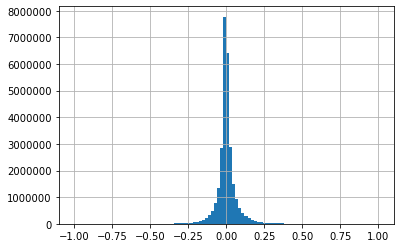

In [181]:
# data = BES_reduced_with_na
corr_mat = BES_reduced_with_na.corr()
# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

In [182]:
thresh = .05
x = ( ( corr_mat>(1-thresh) ) & mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], BES_reduced_with_na[a].notnull().mean(), BES_reduced_with_na[b].notnull().mean() ) )

x = ( ( corr_mat<(thresh-1) ) & mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], BES_reduced_with_na[a].notnull().mean(), BES_reduced_with_na[b].notnull().mean() ) )    

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.
('generalElectionCertaintyW5__Not at all certain', 'generalElectionCertaintyUnsqW5__Not at all certain', 1.0, 0.26000410424789655, 0.208441789884109)
('generalElectionCertaintyW5__Not at all certain', 'generalElectionCertaintySqW5__Not at all certain', 1.0, 0.26000410424789655, 0.051562314363787574)
('generalElectionCertaintyW12__Not at all certain', 'generalElectionCertaintyUnsqW12__Not at all certain', 1.0, 0.27428256666702666, 0.22846619935844126)
('ptvConW1__Very unlikely', 'likeConW1__Strongly like', 1.0, 0.15519457375225465, 0.1588667955544515)
('ptvConW1__Very unlikely', 'likeUKIPW1__Strongly like', 0.9999999999999998, 0.15519457375225465, 0.15342326676531262)
('eesEUIntegrationConW1__Unification should be pushed further', 'ptvLabW1__Very unlikely', 1.0, 0.1253199693261473, 0.1553781848423645)
('eesEUIntegrationConW1__Unification should b

('expectationDevoScotW3__It will neither gain nor lose any powers', 'govtHandleLevelCrimeW1__Very well', 1.0, 0.051065484355255056, 0.05191873589164785)
('scotUnionEconomyW3__Very unlikely', 'govtHandleCostLiveW1__Very well', 1.0, 0.053560435050277036, 0.05286919329927527)
('scotUnionEconomyW3__Very unlikely', 'govtHandleEconW1__Very well', 1.0, 0.053560435050277036, 0.05293399721343169)
('scotUnionEconomyW3__Very unlikely', 'govtHandleImmigW1__Very well', 1.0, 0.053560435050277036, 0.05265318025208723)
('scotUnionEconomyW3__Very unlikely', 'govtHandleNHSW1__Very well', 1.0, 0.053560435050277036, 0.05275038612332185)
('scotUnionEconomyW3__Very unlikely', 'govtHandleEducW1__Very well', 1.0, 0.053560435050277036, 0.051087085659973865)
('scotUnionEconomyW3__Very unlikely', 'govtHandleLevelCrimeW1__Very well', 1.0, 0.053560435050277036, 0.05191873589164785)
('scotUnionMeBetterOffW3__Very unlikely', 'govtHandleCostLiveW1__Very well', 1.0, 0.05391685657813732, 0.05286919329927527)
('scotUnio

('preferMPDisabledW6__Slightly more', 'EUIntegrationLDW4__Unite fully with the European Union', 1.0, 0.06860574378692473, 0.12799853111127912)
('preferMPDisabledW6__Slightly more', 'EUIntegrationLDW6__Unite fully with the European Union', 0.9999999999999999, 0.06860574378692473, 0.12603281238186786)
('preferMPYoungW6__Slightly more', 'ptvConW1__Very unlikely', 0.9878291611472622, 0.070625465778133, 0.15519457375225465)
('preferMPYoungW6__Slightly more', 'ptvUKIPW1__Very unlikely', 1.0, 0.070625465778133, 0.15620983507403846)
('preferMPEthnicW6__Slightly more', 'ptvConW1__Very unlikely', 0.9878291611472622, 0.07101428926307149, 0.15519457375225465)
('preferMPEthnicW6__Slightly more', 'ptvUKIPW1__Very unlikely', 1.0, 0.07101428926307149, 0.15620983507403846)
('preferMPChristW6__Slightly more', 'EUIntegrationConW4__Unite fully with the European Union', 1.0, 0.05891755862054068, 0.13702787648373962)
('preferMPChristW6__Slightly more', 'EUIntegrationLabW4__Unite fully with the European Unio

('warmGreeceW7__Very warm', 'EUIntegrationUKIPW4__Unite fully with the European Union', 1.0, 0.07629580826681931, 0.14057049045762365)
('warmGreeceW7__Very warm', 'EUIntegrationSelfW6__Unite fully with the European Union', 1.0, 0.07629580826681931, 0.14613282642271594)
('warmGreeceW7__Very warm', 'EUIntegrationLabW6__Unite fully with the European Union', 1.0, 0.07629580826681931, 0.13153034443280373)
('warmGreeceW7__Very warm', 'EUIntegrationLDW6__Unite fully with the European Union', 1.0, 0.07629580826681931, 0.12603281238186786)
('warmGreeceW7__Very warm', 'EUIntegrationUKIPW6__Unite fully with the European Union', 0.951189731211342, 0.07629580826681931, 0.1400412584920129)
('warmSpainW7__Very warm', 'EUIntegrationLabW4__Unite fully with the European Union', 1.0, 0.07696544871310228, 0.13299923315368248)
('warmSpainW7__Very warm', 'EUIntegrationLabW6__Unite fully with the European Union', 1.0, 0.07696544871310228, 0.13153034443280373)
('warmSpainW7__Very warm', 'EUIntegrationLDW6__Un

('ptvConW8__Very unlikely', 'riskUnemploymentW7__Very unlikely', 1.0, 0.0904230615529178, 0.30304470390011556)
('ptvConW8__Very unlikely', 'childBenefitsRepatriateW7__Yes, the same amount as UK citizens', 0.9999999999999999, 0.0904230615529178, 0.3126788858047026)
('ptvConW8__Very unlikely', 'tuSupportW7__Mainly remain', 1.0, 0.0904230615529178, 0.2600581075096936)
('ptvConW8__Very unlikely', 'turkeyW7__Worse', 1.0, 0.0904230615529178, 0.2765939062719388)
('ptvConW8__Very unlikely', 'lrUKIPW7__Right', 1.0, 0.0904230615529178, 0.2567207059306382)
('ptvConW8__Very unlikely', 'redistConW7__Government should try to make incomes equal', 1.0, 0.0904230615529178, 0.25376132718416194)
('ptvLabW8__Very unlikely', 'partyIdStrengthW7__Very strong', 0.9683296637314885, 0.09052026742415242, 0.2847159968462095)
('ptvLabW8__Very unlikely', 'ethno5W7__Strongly agree', 0.9561828874675149, 0.09052026742415242, 0.31757158132351193)
('ptvLabW8__Very unlikely', 'likeCorbynW7__Strongly like', 0.974558628915

('euID1W12__Strongly disagree', 'cspl2W7__Usually acceptable', 1.0, 0.07072267164936762, 0.0757881776059274)
('euID1W12__Strongly disagree', 'cspl3W7__£7,500', 1.0, 0.07072267164936762, 0.05036344195189389)
('euID1W12__Strongly disagree', 'csplRank_1W7__Second most common reason', 1.0, 0.07072267164936762, 0.08382386296132287)
('euID2W12__Strongly disagree', 'happyLeaveW7__Very unhappy', 1.0, 0.07643621674749154, 0.07526974629267608)
('euID2W12__Strongly disagree', 'cspl2W7__Usually acceptable', 1.0, 0.07643621674749154, 0.0757881776059274)
('euID2W12__Strongly disagree', 'csplRank_1W7__Second most common reason', 1.0, 0.07643621674749154, 0.08382386296132287)
('euID7W12__Strongly disagree', 'certaintyEUUKIPW7__Very certain', 1.0, 0.06877855422467517, 0.06700724723773316)
('ptvConW12__Very unlikely', 'euScepticismW7__Work towards single European government', 1.0, 0.0865348267035329, 0.07327162560618661)
('ptvConW12__Very unlikely', 'natSecurityLDW7__Protect civil liberties', 1.0, 0.086

('englishnessW12__Very strongly English', 'controlImmigW11__Some control', 1.0, 0.09468931923488179, 0.30471880501582294)
('englishnessW12__Very strongly English', 'euPriorityBalanceW11__Control immigration', 1.0, 0.09468931923488179, 0.2975687731538985)
('englishnessW12__Very strongly English', 'effectsEUImmigrationW11__Much lower', 1.0, 0.09468931923488179, 0.3082938209467852)
('englishnessW12__Very strongly English', 'effectsEUNHSW11__Worse', 1.0, 0.09468931923488179, 0.30340112542797587)
('englishnessW12__Very strongly English', 'UKsovereigntyPostW11__Much more likely', 1.0, 0.09468931923488179, 0.29605668182358214)
('englishnessW12__Very strongly English', 'immigEconW11__Good for economy', 1.0, 0.09468931923488179, 0.3130677092896411)
('englishnessW12__Very strongly English', 'immigSelfW11__Allow many more', 1.0, 0.09468931923488179, 0.3014246060462052)
('englishnessW12__Very strongly English', 'changeEconomyW11__Staying about the same', 1.0, 0.09468931923488179, 0.315022627366692

('econGenRetroW12__Stayed the same', 'changeEducationW11__Staying about the same', 1.0, 0.09034745698640198, 0.30027973689610854)
('econGenRetroW12__Stayed the same', 'changeImmigW11__Staying about the same', 1.0, 0.09034745698640198, 0.3064577100456868)
('econGenRetroW12__Stayed the same', 'wcEconW11__Stayed the same', 1.0, 0.09034745698640198, 0.28998671519759794)
('econGenRetroW12__Stayed the same', 'prefTradeoffW11__Strongly agree', 1.0, 0.09034745698640198, 0.31062676185641613)
('econGenRetroW12__Stayed the same', 'howToReduceDeficitW11__Only by increasing taxes', 1.0, 0.09034745698640198, 0.2823830559365786)
('econGenRetroW12__Stayed the same', 'warmWhiteW11__Very warm', 1.0, 0.09034745698640198, 0.30885545486947413)
('econGenRetroW12__Stayed the same', 'warmAsianW11__Very warm', 1.0, 0.09034745698640198, 0.30510762850076145)
('econGenRetroW12__Stayed the same', 'warmBlackW11__Very warm', 1.0, 0.09034745698640198, 0.3056692624234504)
('overseasAidW12__Strongly agree', 'winConstit

('competentMayW13__No competence at all', 'euID3W8__Strongly disagree', 1.0, 0.15536738419000506, 0.05326881743657317)
('competentMayW13__No competence at all', 'euID5W8__Strongly disagree', 1.0, 0.15536738419000506, 0.05214554959119531)
('ageW13', 'ageW1', 0.9964555557314937, 0.3362891118623565, 0.3281886225928046)
('ageW13', 'ageW7', 0.9995398545675799, 0.3362891118623565, 0.33368615464374046)
('ageW13', 'ageW8', 0.9998535592098361, 0.3362891118623565, 0.3618434553447028)
('ageW13', 'ageW9', 0.9999216083674396, 0.3362891118623565, 0.32440839426701373)
('ageW13', 'ageW11', 0.9994979078556573, 0.3362891118623565, 0.334344994437664)
('ageW13', 'ageW12', 0.9998164854560413, 0.3362891118623565, 0.37147763724928984)
('ageW14', 'ageW1', 0.9967563285070296, 0.3355006642401201, 0.3281886225928046)
('ageW14', 'ageW7', 0.9996024780654461, 0.3355006642401201, 0.33368615464374046)
('ageW14', 'ageW8', 0.9995515992568986, 0.3355006642401201, 0.3618434553447028)
('ageW14', 'ageW9', 0.999370802067204

('generalElectionVoteW13_Scottish National Party (SNP)', 'generalElectionVoteUnsqueezeW11_Scottish National Party (SNP)', 0.9501851052168311, 0.29992331536824823, 0.218799615496776)
('generalElectionVoteW13_Scottish National Party (SNP)', 'generalElectionVoteUnsqueezeW12_Scottish National Party (SNP)', 0.9605304502136439, 0.29992331536824823, 0.22736453281778218)
('generalElectionVoteW14_Scottish National Party (SNP)', 'generalElectionVoteUnsqueezeW12_Scottish National Party (SNP)', 0.9525027831811435, 0.25782237247129725, 0.22736453281778218)
('generalElectionVoteW15_Scottish National Party (SNP)', 'generalElectionVoteUnsqueezeW11_Scottish National Party (SNP)', 0.9550867988826282, 0.21711471372870922, 0.218799615496776)
('generalElectionVoteW15_Scottish National Party (SNP)', 'generalElectionVoteUnsqueezeW12_Scottish National Party (SNP)', 0.9519704619268536, 0.21711471372870922, 0.22736453281778218)
('generalElectionVoteTIGW15_Conservative', 'generalElectionVoteW15_Conservative', 0.

('educationW8W9W10_University or CNAA higher degree (eg M.Sc, Ph.D)', 'educationW7_University or CNAA higher degree (eg M.Sc, Ph.D)', 0.969308362534297, 0.4540162225798438, 0.32234546966636785)
('educationW8W9W10_No formal qualifications', 'educationW7_No formal qualifications', 0.9530004688674732, 0.4540162225798438, 0.32234546966636785)
('educationW8W9W10_Nursing qualification (eg SEN, SRN, SCM, RGN)', 'educationW7_Nursing qualification (eg SEN, SRN, SCM, RGN)', 0.9592078447262057, 0.4540162225798438, 0.32234546966636785)
('educationW9_University or CNAA first degree (eg BA, B.Sc, B.Ed)', 'educationW7_University or CNAA first degree (eg BA, B.Sc, B.Ed)', 0.9576682065364543, 0.314190977135019, 0.32234546966636785)
('educationW9_University or CNAA first degree (eg BA, B.Sc, B.Ed)', 'educationW8W9W10_University or CNAA first degree (eg BA, B.Sc, B.Ed)', 0.9672918022463953, 0.314190977135019, 0.4540162225798438)
('educationW9_University or CNAA higher degree (eg M.Sc, Ph.D)', 'educationW

('gorW14_West Midlands', 'gorW12_West Midlands', 0.9859871371523993, 0.3355006642401201, 0.37147763724928984)
('gorW14_East Midlands', 'gorW11_East Midlands', 0.9797197132742489, 0.3355006642401201, 0.334344994437664)
('gorW14_East Midlands', 'gorW12_East Midlands', 0.983827676889615, 0.3355006642401201, 0.37147763724928984)
('gorW14_Wales', 'country_Wales', 0.9677631824907842, 0.3355006642401201, 0.7203495091103502)
('gorW14_Wales', 'gorW11_Wales', 0.9911182668356867, 0.3355006642401201, 0.334344994437664)
('gorW14_Wales', 'gorW12_Wales', 0.9908335774290074, 0.3355006642401201, 0.37147763724928984)
('gorW14_North East', 'gorW11_North East', 0.9907159497125895, 0.3355006642401201, 0.334344994437664)
('gorW14_North East', 'gorW12_North East', 0.9904095200070328, 0.3355006642401201, 0.37147763724928984)
('localElectionVoteW14_Liberal Democrat', 'spendMost3W3_Infrastructure: Roads and Public Transport', 1.0, 0.09207556136390638, 0.05273958547096245)
('localElectionVoteW14_Liberal Democrat

('localElectionVoteW16_Green Party', 'scotElectionVoteListW6_Scottish National Party (SNP)', 1.0, 0.10901098426344952, 0.05217795154827352)
('workingStatusW16_Retired', 'workingStatusW15_Retired', 0.9592265604774782, 0.3967403631179323, 0.21825958287880587)
('educationW16_University or CNAA first degree (eg BA, B.Sc, B.Ed)', 'educationW15_University or CNAA first degree (eg BA, B.Sc, B.Ed)', 0.9716042237738016, 0.3918152656420448, 0.3202393424562844)
('educationW16_University or CNAA higher degree (eg M.Sc, Ph.D)', 'educationW15_University or CNAA higher degree (eg M.Sc, Ph.D)', 0.9691016539344978, 0.3918152656420448, 0.3202393424562844)
('educationW16_No formal qualifications', 'educationW15_No formal qualifications', 0.9608460958069373, 0.3918152656420448, 0.3202393424562844)
('ns_sec_analyticW16_Employers in large organisations and higher managerial', 'ns_secW16_Higher managerial and administrative occupations', 0.9594268286052968, 0.32473241383779583, 0.32473241383779583)
('miilabe

('gorW3_North West', 'gorW11_North West', 0.9687053926300843, 0.30065775972868763, 0.334344994437664)
('gorW3_North West', 'gorW12_North West', 0.9684580262614008, 0.30065775972868763, 0.37147763724928984)
('gorW3_North West', 'gorW14_North West', 0.9605264366239685, 0.30065775972868763, 0.3355006642401201)
('gorW3_North West', 'gorW15_North West', 0.9551883261992705, 0.30065775972868763, 0.33311372006869217)
('gorW3_North West', 'gorW16_North West', 0.9532189467794737, 0.30065775972868763, 0.40998196291055977)
('gorW3_North West', 'gorW13_North West', 0.9700389066820487, 0.30065775972868763, 0.3346582133560867)
('gorW3_North West', 'gorW2_North West', 0.9901627103177099, 0.30065775972868763, 0.32906347543391623)
('gorW3_East of England', 'gorW2_East of England', 0.9859699389741416, 0.30065775972868763, 0.32906347543391623)
('gorW3_South West', 'gorW11_South West', 0.9515886098360041, 0.30065775972868763, 0.334344994437664)
('gorW3_South West', 'gorW12_South West', 0.9516127836242216, 

('gor_Wales', 'gorW11_Wales', 0.9740281167403222, 0.7203603097627097, 0.334344994437664)
('gor_Wales', 'gorW12_Wales', 0.9743382411181907, 0.7203603097627097, 0.37147763724928984)
('gor_Wales', 'gorW14_Wales', 0.9677631824907842, 0.7203603097627097, 0.3355006642401201)
('gor_Wales', 'gorW15_Wales', 0.9592705522103794, 0.7203603097627097, 0.33311372006869217)
('gor_Wales', 'gorW16_Wales', 0.9608842504281871, 0.7203603097627097, 0.40998196291055977)
('gor_Wales', 'gorW13_Wales', 0.9728402879771448, 0.7203603097627097, 0.3346582133560867)
('gor_Wales', 'gorW2_Wales', 0.9942093876294549, 0.7203603097627097, 0.32906347543391623)
('gor_Wales', 'gorW3_Wales', 0.9896647832258189, 0.7203603097627097, 0.30065775972868763)
('gor_Wales', 'gorW6_Wales', 0.9812730643791836, 0.7203603097627097, 0.3087150463888019)
('gor_Yorkshire and the Humber', 'gorW11_Yorkshire and the Humber', 0.9722045256257041, 0.7203603097627097, 0.334344994437664)
('gor_Yorkshire and the Humber', 'gorW12_Yorkshire and the Hum

('profile_marital_statW13_Widowed', 'profile_marital_statW11_Widowed', 0.9938775241013699, 0.3362891118623565, 0.334344994437664)
('profile_marital_statW13_Separated (after being married)', 'profile_marital_statW11_Separated (after being married)', 0.9849843100491867, 0.3362891118623565, 0.334344994437664)
('profile_marital_statW13_Civil Partnership', 'profile_marital_statW11_Civil Partnership', 0.9662483644492982, 0.3362891118623565, 0.334344994437664)
('profile_newspaperW13_None', 'profile_newspaperW11_None', 0.9540538706761482, 0.3362891118623565, 0.334344994437664)
('profile_newspaperW13_The Daily Mail / The Scottish Daily Mail', 'profile_newspaperW11_The Daily Mail / The Scottish Daily Mail', 0.957748279840388, 0.3362891118623565, 0.334344994437664)
('profile_newspaperW13_The Guardian', 'profile_newspaperW11_The Guardian', 0.9615234792008271, 0.3362891118623565, 0.334344994437664)
('profile_newspaperW13_The Sun', 'profile_newspaperW11_The Sun', 0.9549100698044753, 0.33628911186235

('profile_marital_statW16_Married', 'profile_marital_statW15_Married', 0.9971083703714793, 0.40983075377752815, 0.3330597168068951)
('profile_marital_statW16_Never married', 'profile_marital_statW15_Never married', 0.9922261870073967, 0.40983075377752815, 0.3330597168068951)
('profile_marital_statW16_Living as married', 'profile_marital_statW15_Living as married', 0.9884066940143477, 0.40983075377752815, 0.3330597168068951)
('profile_marital_statW16_Divorced', 'profile_marital_statW15_Divorced', 0.9889046755192837, 0.40983075377752815, 0.3330597168068951)
('profile_marital_statW16_Widowed', 'profile_marital_statW15_Widowed', 0.9911391966965806, 0.40983075377752815, 0.3330597168068951)
('profile_marital_statW16_Separated (after being married)', 'profile_marital_statW15_Separated (after being married)', 0.9774982498205271, 0.40983075377752815, 0.3330597168068951)
('profile_religionW16_No, I do not regard myself as belonging to any particular religion.', 'profile_religionW15_No, I do not 

('mii_catW3_environment', 'miilabelW3_environment', 0.9503420078410325, 0.2618510158013544, 0.2110123451456468)
('mii_catW3_unemployment', 'miilabelW3_unemployment', 0.9581030355120206, 0.2618510158013544, 0.2110123451456468)
('mii_catW3_europe', 'miilabelW3_europe', 0.9688721640602119, 0.2618510158013544, 0.2110123451456468)
('mii_catW3_housing', 'miilabelW3_housing', 0.9881069854522212, 0.2618510158013544, 0.2110123451456468)
('mii_catW3_education', 'miilabelW3_education', 0.9880401098131495, 0.2618510158013544, 0.2110123451456468)
('mii_catW3_taxation', 'miilabelW3_taxation', 0.9540372848276523, 0.2618510158013544, 0.2110123451456468)
('mii_catW3_inflation', 'miilabelW3_inflation', 0.9733029676934147, 0.2618510158013544, 0.2110123451456468)
('LRAL_mii_catW7_Lib-auth', 'ptvLDW8__Very unlikely', 0.9901475429766744, 0.2925356691544169, 0.08972101914955663)
('LRAL_mii_catW3_General-negativity', 'miilabelW3_politics-neg', 0.951717845934559, 0.2411569658807392, 0.2110123451456468)
('small

('ldPriorities2_costLiveW4_Yes', 'eesEUIntegrationLDW1__Unification should be pushed further', 1.0, 0.05420847419184119, 0.12055688163565079)
('ldPriorities2_nhsW4_Yes', 'likeConW1__Strongly like', 1.0, 0.05420847419184119, 0.1588667955544515)
('ldPriorities2_nhsW4_Yes', 'likeLabW1__Strongly like', 1.0, 0.05420847419184119, 0.15884519424973267)
('ldPriorities2_nhsW4_Yes', 'likeGrnW1__Strongly like', 1.0, 0.05420847419184119, 0.15004266257681964)
('ldPriorities2_nhsW4_Yes', 'eesEUIntegrationSelfW1__Unification should be pushed further', 1.0, 0.05420847419184119, 0.1361206216855498)
('ldPriorities2_nhsW4_Yes', 'eesEUIntegrationLabW1__Unification should be pushed further', 1.0, 0.05420847419184119, 0.12119412012485554)
('ldPriorities2_nhsW4_Yes', 'eesEUIntegrationLDW1__Unification should be pushed further', 1.0, 0.05420847419184119, 0.12055688163565079)
('ldPriorities2_crimeW4_Yes', 'likeConW1__Strongly like', 1.0, 0.05420847419184119, 0.1588667955544515)
('ldPriorities2_crimeW4_Yes', 'li

('prPreferenceW9_That one party get more than half the seats in parliament so it can govern on its own', 'EUIntegrationLDW4__Unite fully with the European Union', 0.9958705948858224, 0.06445829328091417, 0.12799853111127912)
('labPriorities_crimeW3_Yes', 'handleMIILDW7__Very well', 1.0, 0.05873394753043084, 0.060451251255575836)
('labPriorities_crimeW3_Yes', 'handleMIIGrnW7__Very well', 0.9948497511671096, 0.05873394753043084, 0.05414367027768477)
('labPriorities_crimeW3_Yes', 'socialDistLDW7__Very unhappy', 0.9682458365518541, 0.05873394753043084, 0.07636061218097573)
('labPriorities_crimeW3_Yes', 'riskUnemploymentW8__Very unlikely', 1.0, 0.05873394753043084, 0.0611640943112964)
('labPriorities_crimeW3_Yes', 'euID3W8__Strongly disagree', 1.0, 0.05873394753043084, 0.05326881743657317)
('conPriorities_nhsW9_Yes', 'csplUncoverWrongsW2__Very confident', 1.0, 0.06775249225053193, 0.05539654595137546)
('conPriorities_costLiveW9_Yes', 'eesEUIntegrationLDW4__Unification should be pushed furth

('labPriorities_costLiveW9_Yes', 'csplConductPublicOfficialsW2__Very low', 1.0, 0.06364824435395898, 0.05231836002894575)
('profile_eurefturnout_Yes', 'euRefTurnoutRetroW9_Yes, voted', 1.0, 0.8032769179258428, 0.3233283290310735)
('profile_eurefvote_Stay/remain in the EU', 'euRefVoteW9_Stay/remain in the EU', 1.0, 0.7063194616954864, 0.303163511076069)
('profile_eurefvote_Stay/remain in the EU', 'euIDW9_The remain side', 0.9650689068106021, 0.7063194616954864, 0.3015758151792368)
('profile_eurefvote_Stay/remain in the EU', 'euRefpastVoteW15_Stay/remain in the EU', 0.9650705226966011, 0.7063194616954864, 0.289533087798503)
('profile_turnout_2015_Yes, voted', 'genElecTurnoutRetroW6_Yes, voted', 1.0, 0.6317517578061715, 0.32423558382926326)
('euRefpastVoteW11_Stay/remain in the EU', 'europeannessW12__Very strongly European', 1.0, 0.3002581355913897, 0.09356605138950393)
('euRefpastVoteW11_Stay/remain in the EU', 'econPersonalRetroW12__Stayed the same', 1.0, 0.3002581355913897, 0.093522848

('belongGroup_111W11_Yes', 'immigSelfW12__Allow many more', 1.0, 0.31591908151252335, 0.08920258783630532)
('belongGroup_111W11_Yes', 'immigLabW12__Allow many more', 1.0, 0.31591908151252335, 0.07787270351129208)
('noChanceCoalitionConW11_Yes', 'europeannessW12__Very strongly European', 1.0, 0.3070949485348915, 0.09356605138950393)
('noChanceCoalitionConW11_Yes', 'econPersonalRetroW12__Stayed the same', 1.0, 0.3070949485348915, 0.09352284878006632)
('noChanceCoalitionConW11_Yes', 'econGenRetroW12__Stayed the same', 1.0, 0.3070949485348915, 0.09034745698640198)
('noChanceCoalitionConW11_Yes', 'immigSelfW12__Allow many more', 1.0, 0.3070949485348915, 0.08920258783630532)
('noChanceCoalitionConW11_Yes', 'immigLabW12__Allow many more', 1.0, 0.3070949485348915, 0.07787270351129208)
('partyContactLabW2_Yes', 'likeSalmondW1__Strongly like', 1.0, 0.09808072407573418, 0.061930940628813984)
('partyContactLabW2_Yes', 'satDemScotW1__Very satisfied', 1.0, 0.09808072407573418, 0.060516055169732255)


('negotiationSpecifics_1W11_Yes', 'immigSelfW12__Allow many more', 1.0, 0.24749694881570847, 0.08920258783630532)
('negotiationSpecifics_1W11_Yes', 'immigLabW12__Allow many more', 1.0, 0.24749694881570847, 0.07787270351129208)
('negotiationSpecifics_3W11_Yes', 'europeannessW12__Very strongly European', 1.0, 0.24749694881570847, 0.09356605138950393)
('negotiationSpecifics_3W11_Yes', 'econPersonalRetroW12__Stayed the same', 1.0, 0.24749694881570847, 0.09352284878006632)
('negotiationSpecifics_3W11_Yes', 'econGenRetroW12__Stayed the same', 1.0, 0.24749694881570847, 0.09034745698640198)
('negotiationSpecifics_3W11_Yes', 'immigSelfW12__Allow many more', 1.0, 0.24749694881570847, 0.08920258783630532)
('negotiationSpecifics_3W11_Yes', 'immigLabW12__Allow many more', 1.0, 0.24749694881570847, 0.07787270351129208)
('noChanceCoalitionGrnW11_Yes', 'europeannessW12__Very strongly European', 1.0, 0.3070949485348915, 0.09356605138950393)
('noChanceCoalitionGrnW11_Yes', 'econPersonalRetroW12__Stayed 

('govtHandleLevelCrimeW3__Very well', 'likeLabW1__Strongly like', -1.0, 0.06832492682558026, 0.15884519424973267)
('govtHandleLevelCrimeW3__Very well', 'likeLDW1__Strongly like', -1.0, 0.06832492682558026, 0.15829436097940316)
('labHandleCostLiveW3__Very well', 'likeLabW1__Strongly like', -1.0, 0.065419551340901, 0.15884519424973267)
('labHandleCostLiveW3__Very well', 'likeLDW1__Strongly like', -1.0, 0.065419551340901, 0.15829436097940316)
('labHandleEconW3__Very well', 'likeLabW1__Strongly like', -1.0, 0.06559236177865144, 0.15884519424973267)
('labHandleEconW3__Very well', 'likeLDW1__Strongly like', -1.0, 0.06559236177865144, 0.15829436097940316)
('labHandleImmigW3__Very well', 'likeLabW1__Strongly like', -1.0, 0.06495512328944668, 0.15884519424973267)
('labHandleImmigW3__Very well', 'likeLDW1__Strongly like', -1.0, 0.06495512328944668, 0.15829436097940316)
('labHandleNHSW3__Very well', 'likeLabW1__Strongly like', -1.0, 0.06577597286876127, 0.15884519424973267)
('labHandleNHSW3__Very

('preferMPLocalW6__Slightly more', 'EUIntegrationLabW4__Unite fully with the European Union', -1.0, 0.07117629904846252, 0.13299923315368248)
('preferMPLocalW6__Slightly more', 'EUIntegrationLDW6__Unite fully with the European Union', -1.0, 0.07117629904846252, 0.12603281238186786)
('preferMPWorkClassW6__Slightly more', 'ptvLabW1__Very unlikely', -0.9607689228305227, 0.07219156037024636, 0.1553781848423645)
('preferMPDisabledW6__Slightly more', 'ptvLabW1__Very unlikely', -1.0, 0.06860574378692473, 0.1553781848423645)
('preferMPDisabledW6__Slightly more', 'ptvLDW1__Very unlikely', -1.0, 0.06860574378692473, 0.15533498223292688)
('preferMPDisabledW6__Slightly more', 'pidInterestedOthersW4__Strongly disagree', -1.0, 0.06860574378692473, 0.06915657705725425)
('preferMPDisabledW6__Slightly more', 'pidRuinDayW4__Strongly disagree', -1.0, 0.06860574378692473, 0.07011783511724108)
('preferMPDisabledW6__Slightly more', 'pidConnectedW4__Strongly disagree', -1.0, 0.06860574378692473, 0.0658731787

('warmPolandW7__Very warm', 'EUIntegrationConW6__Unite fully with the European Union', -1.0, 0.07646861870456975, 0.1364986445181289)
('warmRomaniaW7__Very warm', 'EUIntegrationLabW4__Unite fully with the European Union', -1.0, 0.07514013846436325, 0.13299923315368248)
('warmRomaniaW7__Very warm', 'EUIntegrationConW6__Unite fully with the European Union', -1.0, 0.07514013846436325, 0.1364986445181289)
('warmGreeceW7__Very warm', 'EUIntegrationLabW4__Unite fully with the European Union', -1.0, 0.07629580826681931, 0.13299923315368248)
('warmGreeceW7__Very warm', 'EUIntegrationConW6__Unite fully with the European Union', -1.0, 0.07629580826681931, 0.1364986445181289)
('warmSpainW7__Very warm', 'EUIntegrationConW4__Unite fully with the European Union', -1.0, 0.07696544871310228, 0.13702787648373962)
('warmSpainW7__Very warm', 'EUIntegrationUKIPW4__Unite fully with the European Union', -1.0, 0.07696544871310228, 0.14057049045762365)
('warmSpainW7__Very warm', 'EUIntegrationConW6__Unite ful

('dutyToVote2W8__Strongly agree', 'betterDealEUW7__Worse', -1.0, 0.09421409053106808, 0.2665709008824133)
('dutyToVote2W8__Strongly agree', 'conSupportW7__Mainly remain', -1.0, 0.09421409053106808, 0.283225506820612)
('dutyToVote2W8__Strongly agree', 'cabinetSupportW7__Mainly remain', -0.9999999999999999, 0.09421409053106808, 0.261008564917321)
('dutyToVote2W8__Strongly agree', 'euUndermineIdentityW7__Strongly agree', -1.0, 0.09421409053106808, 0.30902826530722455)
('dutyToVote2W8__Strongly agree', 'lrConW7__Right', -0.9622504486493763, 0.09421409053106808, 0.2653720284705196)
('dutyToVote2W8__Strongly agree', 'lrCorbynW7__Right', -0.9972413740548082, 0.09421409053106808, 0.26843941374058994)
('dutyToVote2W8__Strongly agree', 'satDemEngW7__Very satisfied', -1.0, 0.09421409053106808, 0.236026656010023)
('dutyToVote2W8__Strongly agree', 'redistLabW7__Government should try to make incomes equal', -0.9847319278346618, 0.09421409053106808, 0.25213042867789215)
('dutyToVote2W8__Strongly agre

('ethno6W9__Strongly agree', 'govtHandleEducW4__Very well', -0.9622504486493763, 0.07736507285040016, 0.07544255673042652)
('locus1W9__Strongly agree', 'pidConnectedW3__Strongly disagree', -1.0, 0.08020564442092303, 0.05864754231155562)
('lrLabW9__Right', 'eesEUIntegrationSelfW4__Unification should be pushed further', -1.0, 0.06403706783889747, 0.1386047717282124)
('lrLabW9__Right', 'eesEUIntegrationGreenW4__Unification should be pushed further', -1.0, 0.06403706783889747, 0.09410608400747406)
('lrLDW9__Right', 'csplConductPublicOfficialsW2__Very low', -1.0000000000000002, 0.05973840819985527, 0.05231836002894575)
('lrLDW9__Right', 'eesEUIntegrationSelfW4__Unification should be pushed further', -1.0, 0.05973840819985527, 0.1386047717282124)
('lrLDW9__Right', 'eesEUIntegrationGreenW4__Unification should be pushed further', -1.0, 0.05973840819985527, 0.09410608400747406)
('lrUKIPW9__Right', 'eesEUIntegrationConW4__Unification should be pushed further', -1.0, 0.06278419216520678, 0.125946

('englishnessW12__Very strongly English', 'efficacyNotUnderstandW11__Strongly agree', -1.0, 0.09468931923488179, 0.32629850842990915)
('englishnessW12__Very strongly English', 'efficacyPolCareW11__Strongly agree', -1.0, 0.09468931923488179, 0.3234147342499487)
('englishnessW12__Very strongly English', 'handleEUNegotiateW11__Very well', -1.0, 0.09468931923488179, 0.30583127220884143)
('englishnessW12__Very strongly English', 'effectsEUUnemploymentW11__Much lower', -1.0, 0.09468931923488179, 0.3036495404322421)
('englishnessW12__Very strongly English', 'effectsEUTradeW11__Much lower', -1.0, 0.09468931923488179, 0.3023534621491138)
('englishnessW12__Very strongly English', 'effectsEUTerrorW11__Much lower', -1.0, 0.09468931923488179, 0.3098059122771015)
('englishnessW12__Very strongly English', 'euLeaveVoiceW11__Much lower', -1.0, 0.09468931923488179, 0.31191203948718504)
('englishnessW12__Very strongly English', 'effectsEUWorkersW11__Worse', -1.0, 0.09468931923488179, 0.30774298767645564)

('econGenRetroW12__Stayed the same', 'goodTimePurchaseW11__Neither good nor bad time to buy', -1.0, 0.09034745698640198, 0.2897599014980505)
('econGenRetroW12__Stayed the same', 'riskUnemploymentW11__Very unlikely', -1.0, 0.09034745698640198, 0.3018998347500189)
('econGenRetroW12__Stayed the same', 'econPersonalRetroW11__Stayed the same', -1.0, 0.09034745698640198, 0.3238143583872466)
('econGenRetroW12__Stayed the same', 'econGenRetroW11__Stayed the same', -1.0, 0.09034745698640198, 0.315184637152084)
('econGenRetroW12__Stayed the same', 'redistSelfW11__Government should try to make incomes equal', -1.0, 0.09034745698640198, 0.28926307148951796)
('econGenRetroW12__Stayed the same', 'redistLabW11__Government should try to make incomes equal', -1.0, 0.09034745698640198, 0.2548413924201022)
('econGenRetroW12__Stayed the same', 'antiIntellectualW11__Strongly agree', -1.0, 0.09034745698640198, 0.3171611565338546)
('econGenRetroW12__Stayed the same', 'efficacyUnderstandW11__Strongly agree', 

('immigLabW12__Allow many more', 'conUnitedW11__Very united', -1.0, 0.07787270351129208, 0.2933781200384503)
('immigLabW12__Allow many more', 'ldUnitedW11__Very united', -1.0, 0.07787270351129208, 0.2610733688314774)
('immigLabW12__Allow many more', 'goodTimePurchaseW11__Neither good nor bad time to buy', -1.0, 0.07787270351129208, 0.2897599014980505)
('immigLabW12__Allow many more', 'riskUnemploymentW11__Very unlikely', -1.0, 0.07787270351129208, 0.3018998347500189)
('immigLabW12__Allow many more', 'econPersonalRetroW11__Stayed the same', -1.0, 0.07787270351129208, 0.3238143583872466)
('immigLabW12__Allow many more', 'econGenRetroW11__Stayed the same', -1.0, 0.07787270351129208, 0.315184637152084)
('immigLabW12__Allow many more', 'redistSelfW11__Government should try to make incomes equal', -1.0, 0.07787270351129208, 0.28926307148951796)
('immigLabW12__Allow many more', 'redistLabW11__Government should try to make incomes equal', -1.0, 0.07787270351129208, 0.2548413924201022)
('immigL

('localElectionVoteW7_United Kingdom Independence Party (UKIP)', 'efficacyTooMuchEffortW8__Strongly agree', -1.0, 0.15003186192446025, 0.09152472809357685)
('localElectionVoteW7_United Kingdom Independence Party (UKIP)', 'efficacyNotUnderstandW8__Strongly agree', -1.0, 0.15003186192446025, 0.09406288139803644)
('localElectionVoteW7_United Kingdom Independence Party (UKIP)', 'dutyToVote2W8__Strongly agree', -1.0, 0.15003186192446025, 0.09421409053106808)
('localElectionVoteW7_United Kingdom Independence Party (UKIP)', 'ptvUKIPW8__Very unlikely', -1.0, 0.15003186192446025, 0.0917623424454837)
('localElectionVoteW7_Liberal Democrat', 'antiIntellectualW8__Strongly agree', -1.0, 0.15003186192446025, 0.09180554505492132)
('localElectionVoteW7_Liberal Democrat', 'socialPressureVoteW8__Strongly agree', -1.0, 0.15003186192446025, 0.08946180349293097)
('localElectionVoteW7_Liberal Democrat', 'ptvLabW8__Very unlikely', -1.0, 0.15003186192446025, 0.09052026742415242)
('localElectionVoteW7_Liberal 

('profile_work_typeW11_Sales or Services (e.g. commercial traveller, shop assistant, nursery nurse, care assistant, paramedic)', 'englishnessW12__Very strongly English', -1.0, 0.303055504552475, 0.09468931923488179)
('profile_work_typeW11_Sales or Services (e.g. commercial traveller, shop assistant, nursery nurse, care assistant, paramedic)', 'overseasAidW12__Strongly agree', -1.0, 0.303055504552475, 0.09268039789603293)
('profile_newspaperW11_None', 'britishnessW12__Very strongly British', -1.0, 0.334344994437664, 0.09497013619622625)
('profile_newspaperW11_None', 'englishnessW12__Very strongly English', -1.0, 0.334344994437664, 0.09468931923488179)
('profile_newspaperW11_None', 'overseasAidW12__Strongly agree', -1.0, 0.334344994437664, 0.09268039789603293)
('profile_newspaperW11_The Express', 'europeannessW12__Very strongly European', -1.0, 0.334344994437664, 0.09356605138950393)
('profile_newspaperW11_The Express', 'econPersonalRetroW12__Stayed the same', -1.0, 0.334344994437664, 0.

('conPriorities_immigW3_Yes', 'likeLDW1__Strongly like', -1.0, 0.06077527082635791, 0.15829436097940316)
('conPriorities_immigW3_Yes', 'leaveVoteUKIPConW7__They are evenly split', -1.0, 0.06077527082635791, 0.060915679307030145)
('conPriorities_immigW3_Yes', 'euID1W7__Strongly disagree', -1.0, 0.06077527082635791, 0.06019203559895018)
('conPriorities_immigW3_Yes', 'riskPovertyW8__Very unlikely', -1.0, 0.06077527082635791, 0.06396146327238166)
('conPriorities_immigW3_Yes', 'leaveVoteUKIPConW8__They are evenly split', -1.0, 0.06077527082635791, 0.051691922192100406)
('conPriorities_immigW3_Yes', 'euID3W8__Strongly disagree', -1.0, 0.06077527082635791, 0.05326881743657317)
('conPriorities_crimeW3_Yes', 'handleMIIUKIPW7__Very well', -1.0, 0.06077527082635791, 0.061002084525905366)
('conPriorities_crimeW3_Yes', 'riskPovertyW8__Very unlikely', -1.0, 0.06077527082635791, 0.06396146327238166)
('conPriorities_schoolW3_Yes', 'riskPovertyW8__Very unlikely', -1.0, 0.06077527082635791, 0.0639614632

('responsibleCrimeScottishGovtW1_Yes', 'localEconW15__Stayed the same', -1.0, 0.05067666087031657, 0.06133690474904684)
('responsibleImmigNoneW1_Yes', 'subjectHEW15_Engineering, Mathematics or Natural sciences', -1.0, 0.278073595645177, 0.07494572672189401)
('discussantsSameAddress_1W12_Yes', 'certaintyRedistLabW7__Very certain', -1.0, 0.05178912806333503, 0.05973840819985527)
('discussantsSameAddress_1W12_Yes', 'euID3W7__Strongly disagree', -1.0, 0.05178912806333503, 0.06369144696339658)
('euRefDoOverW11_Yes', 'britishnessW12__Very strongly British', -1.0, 0.30717055310140734, 0.09497013619622625)
('euRefDoOverW11_Yes', 'englishnessW12__Very strongly English', -1.0, 0.30717055310140734, 0.09468931923488179)
('euRefDoOverW11_Yes', 'overseasAidW12__Strongly agree', -1.0, 0.30717055310140734, 0.09268039789603293)
('responsibleCostLiveScotGovtW3_Yes', 'selfEconW15__Stayed the same', -1.0, 0.050460647823128514, 0.06957780249927095)
('responsibleNHSScottishGovtW3_Yes', 'spendPensionsW15__Sp

('partyContactCon_3W2_Yes', 'spendLeast6W3_Social Security', -1.0, 0.06887576009590979, 0.05026623608065927)
('partyContactCon_3W2_Yes', 'scotRefTurnoutW3_W14_Yes, I voted', -1.0, 0.06887576009590979, 0.08511994124445116)
('partyContactCon_3W2_Yes', 'devoResponsibleScotDefenceW3_The UK Parliament', -1.0, 0.06887576009590979, 0.05376564744510568)
('partyContactCon_3W2_Yes', 'devoResponsibleScotPoliceW3_The UK Parliament', -1.0, 0.06887576009590979, 0.0538412520116215)
('partyContactCon_3W2_Yes', 'referendumContact_3W3_Yes', -1.0, 0.06887576009590979, 0.05515893159946861)
('partyContactCon_5W2_Yes', 'snpToneW5__5 - Focused mainly on putting forward their own policies and personalities', -1.0, 0.06887576009590979, 0.057513473813818355)
('partyContactCon_5W2_Yes', 'scotLabW6__Very strongly Scottish', -1.0, 0.06887576009590979, 0.054035663754090746)
('partyContactCon_5W2_Yes', 'referendumSettledW6_Yes', -1.0, 0.06887576009590979, 0.053020402432306914)
('partyContactCon_5W2_Yes', 'snpHopeW6_

In [183]:
# high_corr_drop_list = ['country_Scotland', 'country_Wales', 'polKnowMay_Leader of the Labour Party',
                      # 'polKnowBercow_Home secretary', 'polKnowMiliband_Deputy Prime Minister']

# dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales','BESwave10_Samplesurvey_taken a BES wave',
#                                 'profile_ethnicity_Chinese','profile_ethnicity_Indian','profile_ethnicity_Pakistani',
#                                 'profile_religion_Yes - Islam','housing_Own outright']

dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales']

# dummy_cat_high_corr_drop_list = ['country_Wales', 'profile_ethnicity_Chinese','profile_ethnicity_Indian','profile_ethnicity_Pakistani',
#                                 'profile_religion_Yes - Islam']

BES_reduced.drop( dummy_cat_high_corr_drop_list,axis=1, inplace=True, errors='ignore')
BES_reduced_with_na.drop( dummy_cat_high_corr_drop_list,axis=1, inplace=True, errors='ignore')
print("dummy_cat_high_corr_drop_list", BES_reduced.shape)
print(dummy_cat_high_corr_drop_list)

dummy_cat_high_corr_drop_list (92587, 7605)
['country_Scotland', 'country_Wales']


In [184]:
# %%time
# nans = BES_numeric[[new_old_col_names[col] if col in new_old_col_names.keys() else col for col in BES_reduced.columns ]].isnull()
# nans.to_msgpack( data_subfolder + "nans.msgpack")
# del nans

In [185]:
# very_low_var
# NoiseVariance.loc[very_low_var].sort_values(by='noise_variance_')fc

# upshot - get rid of 

In [186]:
# del BES_imputed, counts_by_individuals, corr_df

In [187]:
# import sys
# for var, obj in locals().items():
#     if ( sys.getsizeof(obj)> 1000000):
#         print(var, sys.getsizeof(obj))

In [188]:
# BES_reduced_with_na_2 = BES_reduced_with_na.apply(pd.to_numeric,downcast='float')
# BES_reduced_with_na_2.dtypes.value_counts()

In [96]:
BES_reduced_with_na.to_pickle( data_subfolder + "BES_reduced_with_na.zip",compression='zip')
BES_reduced.to_pickle( data_subfolder + "BES_reduced.zip",compression='zip')

In [189]:
# BES_reduced_with_na = BES_reduced_with_na.apply(pd.to_numeric,downcast='float')
BES_reduced_with_na.to_msgpack( data_subfolder + "BES_reduced_with_na2.msgpack")

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  


SystemError: <built-in method pack of Packer object at 0x0000000006EDD798> returned NULL without setting an error

In [195]:
assert (BES_reduced==-1).sum().sum()==0
BES_reduced = BES_reduced.apply(pd.to_numeric,downcast='integer')
BES_reduced.to_msgpack( data_subfolder + "BES_reduced.msgpack")

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  This is separate from the ipykernel package so we can avoid doing imports until


In [196]:
assert (BES_reduced_with_na==-1).sum().sum()==0
# BES_reduced_with_na.fillna(-1,inplace=True)
BES_reduced_with_na = BES_reduced_with_na.apply(pd.to_numeric,downcast='integer')
BES_reduced_with_na.to_msgpack( data_subfolder + "BES_reduced_with_na.msgpack")

MemoryError: 

In [97]:
# save decomp object    
fname = data_subfolder + "new_old_col_names.pkl"

with open(fname, "wb") as f:
    pickle.dump( new_old_col_names, f )

In [ ]:
# (BES_data_folder+"BES_reduced_with_na"+wave+".hdf","BES_reduced_with_na"+wave)


In [ ]:
# del BES_numeric,BES_imputed,BES_reduced,BES_Panel,corr_mat,df,mask

In [ ]:

# assert (BES_numeric==-1).sum().sum()==0
# BES_numeric.fillna(-1,inplace=True)
# BES_numeric = BES_numeric.apply(pd.to_numeric,downcast='integer')
# BES_numeric.to_msgpack( data_subfolder + "BESnumeric.msgpack")

In [98]:
gc.collect()

40

In [ ]:
# np.linalg.matrix_rank( BES_reduced.drop(dummy_cat_high_corr_drop_list, axis=1, errors="ignore").values )

In [ ]:
# BES_reduced.drop(dummy_cat_high_corr_drop_list,axis=1,errors="ignore").shape

In [ ]:
# qr = np.linalg.qr(BES_reduced.drop(dummy_cat_high_corr_drop_list,axis=1,errors="ignore").values)[1]

In [ ]:
# qr.shape

In [ ]:
# BES_reduced.drop(dummy_cat_high_corr_drop_list,axis=1,errors="ignore").columns[np.abs(np.sum(qr,axis=1))<.3 ]

In [ ]:
# dummy_cat_high_corr_drop_list.append('xprofile_ethnicity_Pakistani')

In [ ]:
# dummy_cat_high_corr_drop_list

In [ ]:
# dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales','BESwave10_Samplesurvey_taken a BES wave',
#                                 'profile_ethnicity_Chinese','profile_ethnicity_Indian','profile_ethnicity_Pakistani',
#                                 'profile_religion_Yes - Islam','housing_Own outright']

In [ ]:
# [x for x in BES_Panel.columns if 'age' in x.lower()]

In [ ]:
# BES_Panel.shape[0]*.02

In [ ]:
# BES_numeric["likeWoodW1"].notnull().sum()

In [ ]:
# mostly_not_filled_out

In [ ]:
# # a list of dropped variables!
# l = [many_cat_drop_list,
# high_corr_drop_list,
# mostly_not_filled_out,
# very_low_var]

# flat_list = [item for sublist in l for item in sublist]

# fname = data_subfolder + "red_dropped_var"
# with open(fname+".pkl", "wb") as f: pickle.dump( flat_list, f )

In [ ]:

BES_reduced_with_na = BES_reduced_with_na.apply(pd.to_numeric,downcast='float')


In [ ]:
BES_reduced_with_na.dtypes.value_counts()

In [201]:
memory_use(locs = locals().items())

           BES_reduced_with_na:   4.3GiB
                      corr_mat: 442.5MiB
                            df: 220.7MiB
                          mask:  55.2MiB
                      var_type:   5.6MiB
                       corr_df:   3.9MiB
                          _131:   3.9MiB
                          _133:   3.9MiB
                          _137:   3.9MiB
         counts_by_individuals:   1.4MiB


In [ ]:
BES_reduced_with_na.to_msgpack( data_subfolder + "BES_reduced_with_na.msgpack")

In [202]:
del corr_mat, df

